Important Header:   
This is the clean deliverable of my findings if you want to take a deeper dive into the exploration of the data please lookat EDA.ipynb

Since I know this is a project please allow me to make grading it easier. We will get into this below but yy first two datasets are semi-structured json data and my third dataset is tabular.

In [1]:
# All dependencies for this project
from IPython import display
import json, pandas as pd
import geopandas as gdp # I misnamed this and realized way after the fact so just ignore it
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.colors as mcolors
import os
from dotenv import load_dotenv
import requests

# Q: Do historically redlined neighborhoods in Denver still show economic disparities in income, racial composition, or home value today?


### For context
**Redlining** is a term that comes from maps drawn up by the Home Owners' Loan Corporation (HOLC) that color coded neighborhoods based on 'percieved lending risk'  

Areas that were red on the map were marked as 'hazardous' but these red districts were in reality usually just poor, majority black or immigrant communities. 

Residents of red zones were denied mortgages, loans, and insurance. This in practice led to poor communities getting poorer losing critical funding and decreasing property values. (below is a visual aid as to what redlining looked like)

Redlining was made illegal by the Fair Housing Act of 1968, but just because it is now illegal doesnt mean there were not long lasting impacts of redlining and little reperation paid. Redlining's legacy persists across the country but this project will review Denver's historically redlined districts and see if / how much the affects of redlining are still felt today.

Oakland is perhaps one of the best examples of redlining that people are aware of

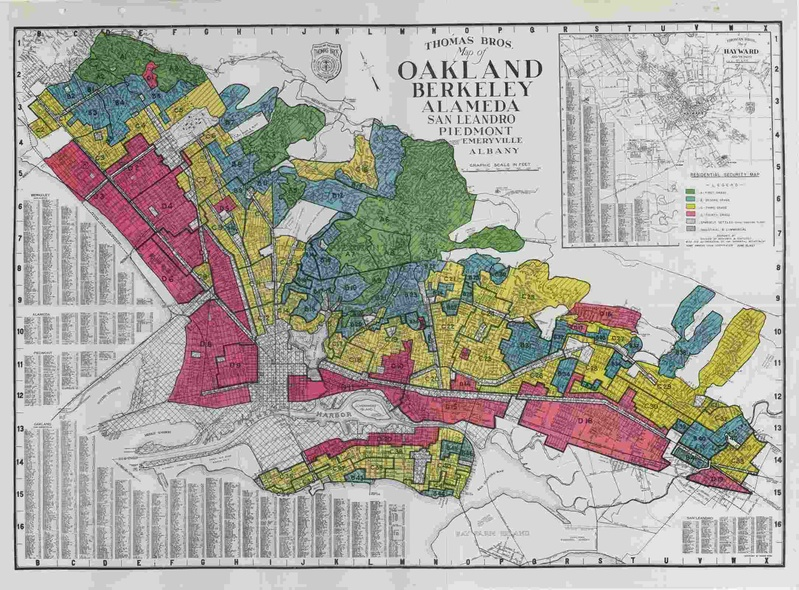

In [2]:
display.Image("./oakland.jpg")

But most major cities have ties to this practice

This map was produced by the HOLC in 1938

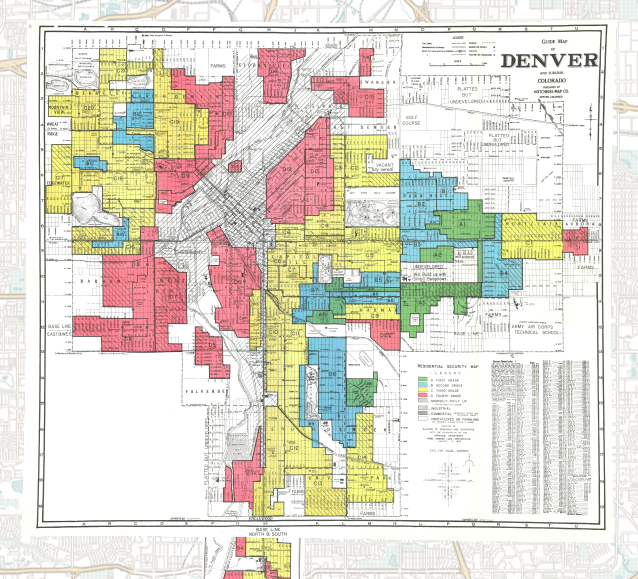

In [3]:
display.Image("./denver.png")

### We can first start by looking at the historical redlining data for Denver.

### Data set \#1 HOLC Redline data

This is GEOJSON data from the University of Richmond "Mapping Inequality" Project.

They have been working to compile and log redline maps from across the country.

I highly recommend checking out the site and their interactive map: https://dsl.richmond.edu/panorama/redlining/

This data contains information and geometry on 1938 HOLC districts with their associated 'grades'

The Grades range from A-D   
A: "Best"   
B: "Still Desirable"    
C: "Definitely Declining"   
D: "Hazardous"  

The issue with these grades is that they are inherently super racist. I really cannot recommend checking out this site enough. For some of the maps they were also able to find original comments from the map makers for their explanations for certain districts and it is appaling. It is so bad that I cannot include these comments in my project but please explore their website they are doing amazing work.

https://dsl.richmond.edu/panorama/redlining/map/CO/Denver/area_descriptions#mapview=full&loc=12/39.7104/-104.9693

This will give you a feel for what the data looks like. I took the json data and put it into a geopandas df to help visualize and work with it.

In [4]:
with open('mappinginequality.json') as f:
    historic_data = json.load(f)

# only grab data that relates to Denver
denver_historic_data = []
for feature in historic_data['features']:
    if feature['properties']['city'] == 'Denver':
        denver_historic_data.append(feature)

denver_gdf = gdp.GeoDataFrame.from_features(denver_historic_data)
denver_gdf.head()

,geometry,area_id,city,state,city_survey,category,grade,label,residential,commercial,industrial,fill
0,"MULTIPOLYGON (((-104.90814 39.74754, -104.9124...",6525,Denver,CO,True,Best,A,A1,True,False,False,#76a865
1,"MULTIPOLYGON (((-104.92221 39.73851, -104.9222...",6529,Denver,CO,True,Best,A,A2,True,False,False,#76a865
2,"MULTIPOLYGON (((-104.91281 39.72538, -104.9128...",6537,Denver,CO,True,Best,A,A3,True,False,False,#76a865
3,"MULTIPOLYGON (((-104.96016 39.72913, -104.9601...",6536,Denver,CO,True,Best,A,A4,True,False,False,#76a865
4,"MULTIPOLYGON (((-104.95956 39.72366, -104.9595...",6540,Denver,CO,True,Best,A,A5,True,False,False,#76a865


In [5]:
# Number of each district
grade_counts = denver_gdf["grade"].value_counts().sort_index()
grade_counts

grade
A     6
B    12
C    20
D    16
Name: count, dtype: int64

<Axes: xlabel='grade'>

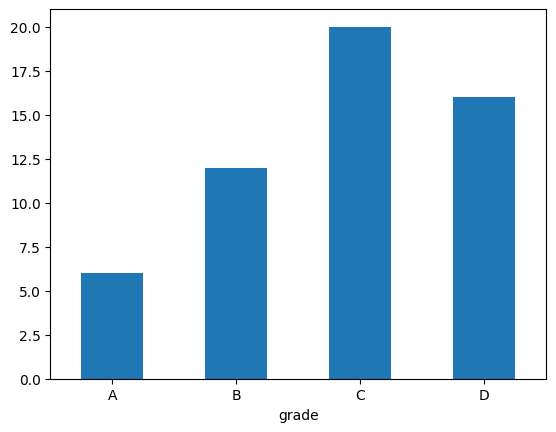

In [6]:
grade_counts.plot(kind="bar",rot=0)
# "rot" rotates the xlables bc their default is sideways?

Denver_gdf is a geopandas.geodataframe.GeoDataFrame object which means it has a few helpful methods and attributes we will need to check starting with crs and bounds.

crs stands for Coordinate Reference System which is essentially just the time standard thing we have talked about earlier in this class but for coordinates. GeoJSON is usually EPSG:4326 (longitude, latitude in degrees[a modern global coordinate system that handles earth as an ellipsoid]) so we need to verify that this is the case and if it is not we will need to update the crs

In [7]:
# None was assigned and we will need a crs for geopandas operations
denver_gdf = denver_gdf.set_crs('EPSG:4326')
print(denver_gdf.crs)

EPSG:4326


ESPG:4326 is a great baseline for our dataset however,

Since I have done this entire project in VS Code it is important to note my VS Code HATES geopandas.explore I have tried a number of work arounds and worked with TAs it is just not in the stars for me. 

I did try my hand at a few .explore interactive examples and got them to run fairly consistently on my machine (to fufill in-class peer feedback) but for the most part I will be using a python library known as **Contextily** 

Contextily is designed specifically to provide real world context for python geo maps

This is the documentation I am following    
https://contextily.readthedocs.io/en/latest/intro_guide.html

Contextily basemaps use EPSG 3857 which is "Web Mercator projection" widely used in online mapping platforms. It is a flat coordinate representation (does not handel the Earth as an ellipsoid).

So what we need to do is make a copy of the denver_gdf transforming the coordinates from ESPG 4326 to ESPG 3857

This is the step that lines up the contextily map with our districts map above

In [8]:
denver_gdf_3857 = denver_gdf.to_crs(epsg=3857)
print(denver_gdf_3857.crs)

EPSG:3857


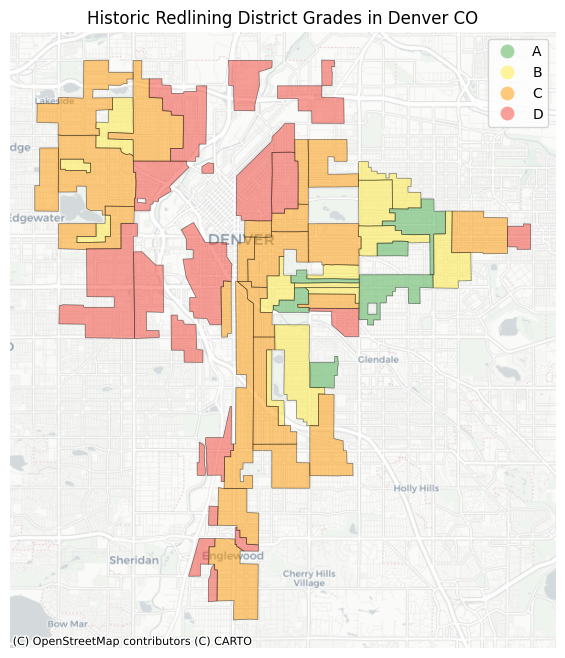

In [9]:


grade_categories = ["A", "B", "C", "D"]
grade_colors = ["#4CAF50", "#FFEB3B", "#FF9800", "#F44336"]

color_map = mcolors.ListedColormap(grade_colors)


ax = denver_gdf_3857.plot(
    column="grade", 
    cmap=color_map,
    categorical=True,
    categories=grade_categories,
    legend=True, 
    figsize=(8, 8), 
    alpha=0.5,
    edgecolor="black",
    linewidth=0.5
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.axis('off') # turned off the axis because it was just nonsense numbers in web mercator
plt.title("Historic Redlining District Grades in Denver CO")
plt.show()

And here is my geopandas.explore() recreation

In [10]:
color_map = mcolors.ListedColormap(grade_colors)

# this is so dumb but geopandas (more specifically leaflet) expects the data to be in crs 4326
# just so internally it can project it into a standardized 3857
denver_redline_map = denver_gdf.explore(
    column="grade",
    categorical=True,
    categories=grade_categories,
    cmap=color_map,
    legend=True,
    tiles="CartoDB positron", #I can use the same base map I was using with contextily
    style_kwds={"fillOpacity": 0.6, "weight": 0.6},
    tooltip=["grade","category"]
)
denver_redline_map.save("denver_redline_map.html")
denver_redline_map


-----

### Data set \#2 US Census Data

'The American Community Survey' comes from the Census Bureau. The actual Census itself is a "'Snapshot' taken every 10 years to distribute political power. The American Community Survey is a continuous 'moving video,' capturing the detailed social and economic portrait of the nation year after year." (govfacts.org)

https://govfacts.org/federal/commerce/census/the-census-vs-the-american-community-survey/

So what the American Community Survey (ACS) is, is a long form survey designed to capture the social, economic, housing, and demographic data from year to year.

The Census bereau provides ample documentation for how to interact with their API but it is through an API Key.

https://www.census.gov/programs-surveys/acs/data/data-via-api.html

In [11]:
# I out this project in a github repo so my API Key is protexted in a .env file
load_dotenv()
api_key = os.getenv("API_KEY")

I chose to try and frame this section of the project around the object oriented principals we have been learning about in class

In [12]:
class CensusAPIrequester:
    def __init__(self, year):
        self.year = year
        self.base_url = f"https://api.census.gov/data/{self.year}/acs/acs5"

    def get_api_groups(self):
        request = requests.get(self.base_url + "/groups.json")
        census_groups = request.json()
        return census_groups
    
    def get_api_group(self, group_code):
        request = requests.get(self.base_url + f"/groups/{group_code}.json")
        group = request.json()
        return group
    
    def get_group_variable(self, group_code, variable_code):
        variable = self.get_api_group(group_code)["variables"][variable_code]
        return variable
    
    # Above code is more for the exploratory side of things
    def get_data(self, variables, state="08", county="031", api_key=api_key):
        var_string = ",".join(variables)
        url = f"{self.base_url}?get={var_string}&for=tract:*&in=state:{state}+county:{county}&key={api_key}"
        response = requests.get(url)
        data = response.json()
        df = pd.DataFrame(data[1:], columns=data[0])
        return df

In [13]:
CensusObject = CensusAPIrequester(2023) #2024 data not out yet

In [14]:
# This is the specific metric I care about though the census data provides more
CensusObject.get_group_variable("B19013","B19013_001E")["label"]

'Estimate!!Median household income in the past 12 months (in 2023 inflation-adjusted dollars)'

This is also a great time to mention, going into this project I had intended to look at a few other metrics such as racial splits, median home cost, median rent cost.

And I got feedback from my peers reinforcing this with suggestions to gather district school ratings and crime statistics.

While I think all of these are great ideas and could really push this project further, I sat down and talked with my TA and we both agreed I have a tendency to overdo homeworks and assignments for this class so we agreed it would be best to stick to one metric so I didnt spend way way too many hours on this project.

In [15]:
census_data = CensusObject.get_data(variables=["B19013_001E"])
census_data = census_data.rename(columns={"B19013_001E":"median_income"})
census_data.head()

,median_income,state,county,tract
0,158906,08,031,000102
1,92237,08,031,000201
2,92621,08,031,000202
3,132875,08,031,000301
4,127554,08,031,000302


------------
## Data set \#3 Also from the US Census Bureau

Topologically Integrated Geographic Encoding and Referencing    
aka "Tiger"

We got valuable information from Data set 2 but we have no way of using it. That is where the US Census TIGER data comes into play. It uses that state, county, tract code as a GEOID to connect these codes to real places

In [16]:
tiger_url = "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_08_tract.zip"
tracts = gdp.read_file(tiger_url)

display.display(tracts.head())

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,08,041,002300,08041002300,1400000US08041002300,23,Census Tract 23,G5020,S,3129892,0,+38.8273607,-104.8263328,"POLYGON ((-104.83615 38.82299, -104.83598 38.8..."
1,08,041,006600,08041006600,1400000US08041006600,66,Census Tract 66,G5020,S,2516901,91797,+38.8687188,-104.8744389,"POLYGON ((-104.88195 38.8566, -104.8819 38.856..."
2,08,041,006100,08041006100,1400000US08041006100,61,Census Tract 61,G5020,S,1355660,0,+38.8327720,-104.7524816,"POLYGON ((-104.75752 38.83876, -104.75751 38.8..."
3,08,041,006200,08041006200,1400000US08041006200,62,Census Tract 62,G5020,S,3609651,0,+38.8323139,-104.7346290,"POLYGON ((-104.74872 38.8261, -104.74869 38.82..."
4,08,035,014300,08035014300,1400000US08035014300,143,Census Tract 143,G5020,S,492002471,1693504,+39.2547440,-105.1569731,"POLYGON ((-105.32922 39.12969, -105.32915 39.1..."


In [17]:
tracts = tracts.loc[tracts["COUNTYFP"] == "031"].copy() # 031 is Denver County

display.display(tracts[["GEOID","NAME"]].head())
print(tracts.crs)

,GEOID,NAME
212,08031002101,21.01
271,08031004404,44.04
272,08031004403,44.03
300,08031003701,37.01
301,08031003702,37.02


EPSG:4269


We can now take our df from Dataset 2 and create a GEOID column using state, county, and tract data

In [18]:
census_data_to_merge = census_data.copy()

census_data_to_merge["GEOID"] = census_data_to_merge["state"] + census_data_to_merge["county"] + census_data_to_merge["tract"]
census_data_to_merge.head()

,median_income,state,county,tract,GEOID
0,158906,08,031,000102,08031000102
1,92237,08,031,000201,08031000201
2,92621,08,031,000202,08031000202
3,132875,08,031,000301,08031000301
4,127554,08,031,000302,08031000302


In [19]:
census_merged = tracts.merge(census_data_to_merge[["GEOID","median_income"]], on="GEOID")

census_merged["median_income"] = pd.to_numeric(census_merged["median_income"]) #was freaking out since it auto cast to string

print(len(tracts), len(census_data_to_merge), len(census_merged)) #should all be the same
display.display(census_merged.head())


178 178 178


,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,median_income
0,08,031,002101,08031002101,1400000US08031002101,21.01,Census Tract 21.01,G5020,S,880925,0,+39.7220354,-104.9938290,"POLYGON ((-105.00019 39.72412, -105.00016 39.7...",143581
1,08,031,004404,08031004404,1400000US08031004404,44.04,Census Tract 44.04,G5020,S,1304208,0,+39.7365094,-104.8940558,"POLYGON ((-104.90346 39.73899, -104.90346 39.7...",58204
2,08,031,004403,08031004403,1400000US08031004403,44.03,Census Tract 44.03,G5020,S,1465389,0,+39.7443925,-104.8948130,"POLYGON ((-104.90346 39.74561, -104.90346 39.7...",85336
3,08,031,003701,08031003701,1400000US08031003701,37.01,Census Tract 37.01,G5020,S,1873267,120383,+39.7444161,-104.9509827,"POLYGON ((-104.95979 39.7452, -104.95978 39.74...",96746
4,08,031,003702,08031003702,1400000US08031003702,37.02,Census Tract 37.02,G5020,S,706200,0,+39.7365218,-104.9543646,"POLYGON ((-104.95979 39.73504, -104.95979 39.7...",76028


We're not quite done with this data yet. We need to clean it. 

We can see there is an egregious outlier at -666666666

<Axes: >

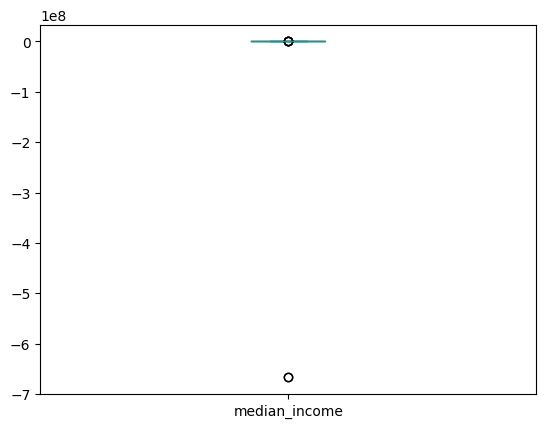

In [20]:
census_merged["median_income"].plot(
    kind="box"
)

This would skew the data    
.   
.   
.   
There is another outlier above 200,000 but I opted to leave it in since I think it helps better represents the data

<Axes: >

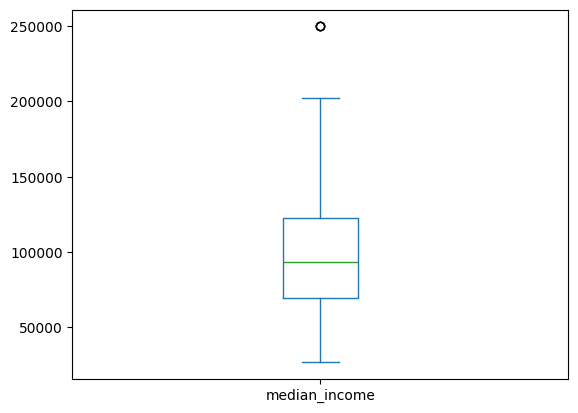

In [21]:
census_merged = census_merged.loc[census_merged["median_income"] >= 0]
census_merged["median_income"].plot(
    kind="box"
)

In [22]:
min_income = census_merged["median_income"].min()
print(min_income)
max_income = census_merged["median_income"].max()
print(max_income)

26462
250001


In [23]:
census_merged_3875 = census_merged.to_crs(3857)

Now that everything is cleaned and dataset 2 and 3 have been combined we can better visualize the distribution of median income in Danver in 2023

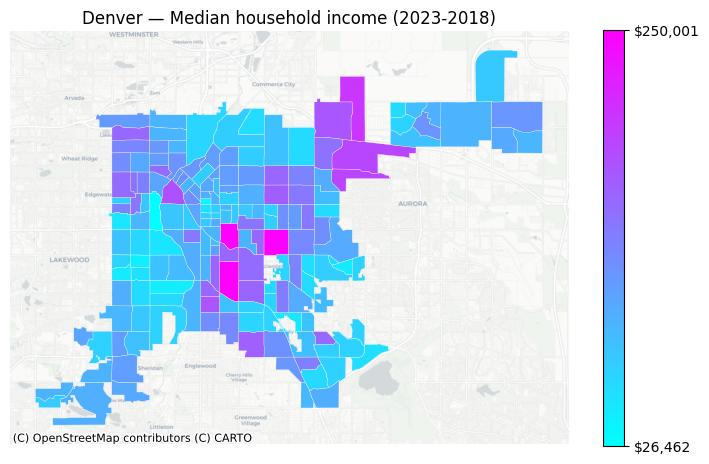

In [24]:
fig, ax = plt.subplots(figsize=(9,9))
census_merged_3875.plot(
    column="median_income",
    cmap="cool", 
    legend=True,
    legend_kwds={
            'ticks': [min_income, max_income], # Set ticks to only min and max to avoid crowding
            'format': '${x:,.0f}', # format as currency
            'shrink': 0.6
    },
    linewidth=0.2,
    edgecolor="white",
    ax=ax
    )

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=12)
ax.set_title("Denver — Median household income (2023-2018)")
ax.set_axis_off()
plt.show()

---------

Now that we have everything pulled in, cleaned, understood, and visualized. Lets
### Put it all together

In [25]:
# renaming these for ease of access
holc = denver_gdf_3857.copy()
tracts = census_merged_3875.copy()

La Piece de Resistance for this project is going to be a spatial merge from the old holc data and the 2023 Census data

How spatial joins work is they join two geodatasets (similar to normal joins) but instead of joining on a common trait spatial joins use a predicate to find the relation between datasets (touch, intersect, etc)

This means this spatial join will look at districts on both sides and create rows for all district overlap. This means if a modern district somehow overlaps with 4 historic districts there will be 4 rows in this new merged data one representing each overlap

In [26]:
holc["holc_geom"] = holc["geometry"]

In [27]:
joined = gdp.sjoin(
    tracts, #left
    holc[["grade", "geometry", "holc_geom"]], #right. Only add grade and geomotry to tracts data
    how="inner",
    predicate="intersects",
)

# above is all we really need for the join
# below is where we start doing tricks on it

joined['intersection_geometry'] = joined['geometry'].intersection(joined['holc_geom'])
joined['area_overlapped'] = joined['intersection_geometry'].area
joined = joined.drop(columns=['intersection_geometry', 'holc_geom'])
joined.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,median_income,index_right,grade,area_overlapped
0,08,031,002101,08031002101,1400000US08031002101,21.01,Census Tract 21.01,G5020,S,880925,0,+39.7220354,-104.9938290,"POLYGON ((-11688567.461 4825932.766, -11688563...",143581,19,C,443851.111573
0,08,031,002101,08031002101,1400000US08031002101,21.01,Census Tract 21.01,G5020,S,880925,0,+39.7220354,-104.9938290,"POLYGON ((-11688567.461 4825932.766, -11688563...",143581,54,None,128503.559644
0,08,031,002101,08031002101,1400000US08031002101,21.01,Census Tract 21.01,G5020,S,880925,0,+39.7220354,-104.9938290,"POLYGON ((-11688567.461 4825932.766, -11688563...",143581,50,D,918562.707475
1,08,031,004404,08031004404,1400000US08031004404,44.04,Census Tract 44.04,G5020,S,1304208,0,+39.7365094,-104.8940558,"POLYGON ((-11677799.972 4828085.05, -11677799....",58204,12,B,206945.277203
1,08,031,004404,08031004404,1400000US08031004404,44.04,Census Tract 44.04,G5020,S,1304208,0,+39.7365094,-104.8940558,"POLYGON ((-11677799.972 4828085.05, -11677799....",58204,38,D,11127.152637


So what just happened there is when the sjoin happens it calculates the overlap but doesnt store that (and that is a hard feat to get it to store somewhere) So I made a new column that calculates the area of overlap for each row.

The reason this is important is because there are a lot of areas on the map below that are "technically" overlapping but are really more just boardering eachother and I think it would be unrepresentative of the data if we include those counties in our future calculations since realistically there is no real overlap between the historic data and the current data.

This is skipping ahead a little but this screenshot below shows an example of what I mean. The red outline is the redline data and the blue districts are from the census data. In our df these were counted as overlap and were affecting the results of our experimentation so I went through and dropped districts that didnt meet a minimum area_overlapped threshold

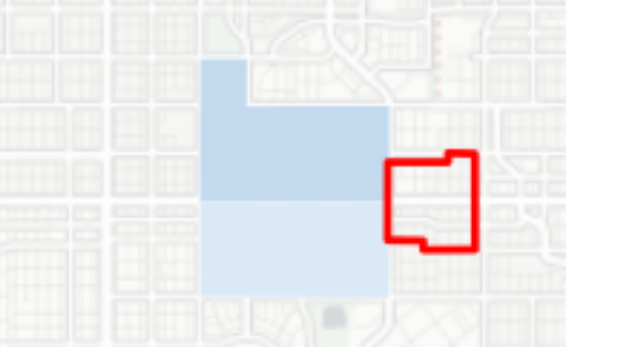

In [28]:
display.Image("./bad_example.png")

In [29]:
# I explored this more in the EDA but landed on 18000 being the magic number to rid all slight bordered districts
joined = joined.loc[joined["area_overlapped"]>=18000]

In [30]:
joined["median_income"] = pd.to_numeric(joined["median_income"]) #was freaking out since it auto cast to string
joined["grade"].value_counts()

grade
C    89
D    52
B    42
A    16
Name: count, dtype: int64

Using this merged data lets look at the 2023 average median income when broken down by what historic districts they used to belong to

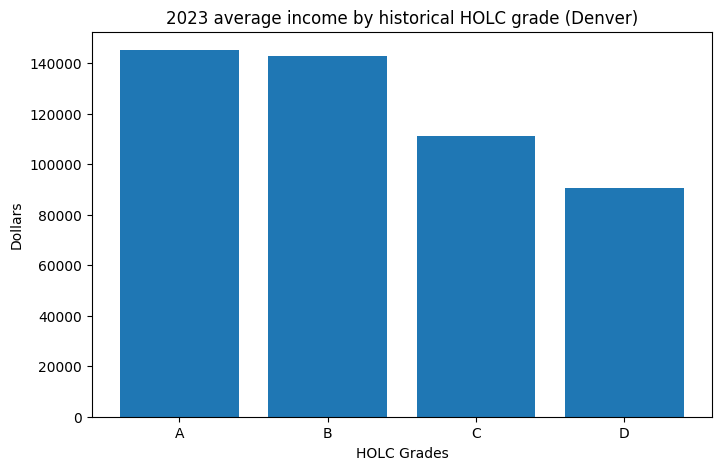

In [31]:
summary = joined.groupby("grade")["median_income"].mean().sort_index()
plt.figure(figsize=(8,5))
plt.bar(x=summary.index, height=summary.values)
plt.title("2023 average income by historical HOLC grade (Denver)")
plt.xlabel("HOLC Grades")
plt.ylabel("Dollars")
plt.show()

This graph clearly shows that there is still economic disparity in these historic redlined districts. This alone proves the point I was trying to make.

But I would love to help show the user what that disparity realistically looks like on a map today.

To do this I will isolate the redline districts (Grade D) and try to plot the current and old areas.

A lot of work went into this which is explained in the EDA but here is that visual

In [32]:
redlined = joined[joined["grade"] == "D"].copy()

# limits for the legend and color map
vmin_all = joined["median_income"].min()
vmax_all = joined["median_income"].max()

vmin_red = redlined["median_income"].min()
vmax_red = redlined["median_income"].max()

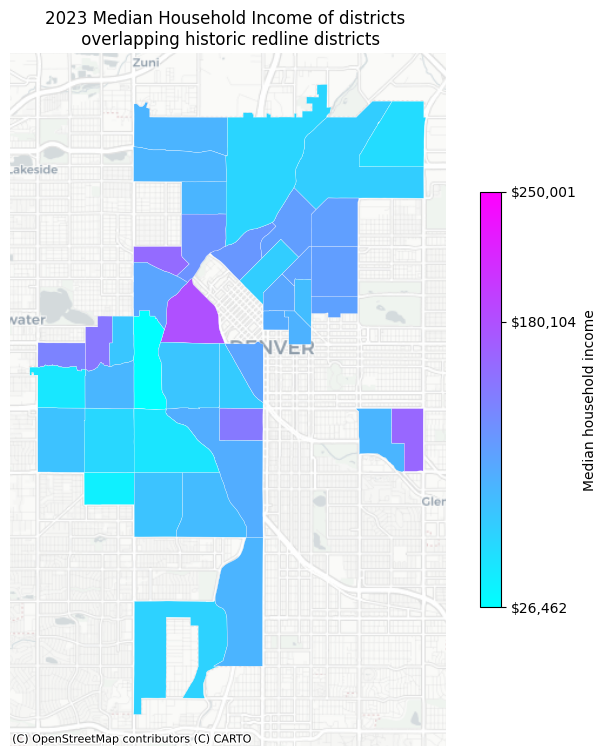

In [33]:
#This is just the visualization of affected districts and their 2023 median incomes
#Because it feels less busy and easier to take as a first bite
fig, ax = plt.subplots(figsize=(9, 9))

redlined.plot(
    column="median_income",
    cmap="cool",
    legend=True,
    legend_kwds={
        "ticks":[vmax_all,vmax_red,vmin_red],
        "label": "Median household income",
        "format": '${x:,.0f}',
        "shrink": 0.6,
    },
    linewidth=0.2,
    edgecolor="white",
    ax=ax,
    vmax=vmax_all,
    vmin=vmin_all
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=12)
ax.set_title("2023 Median Household Income of districts \n overlapping historic redline districts")
ax.set_axis_off()
plt.show()


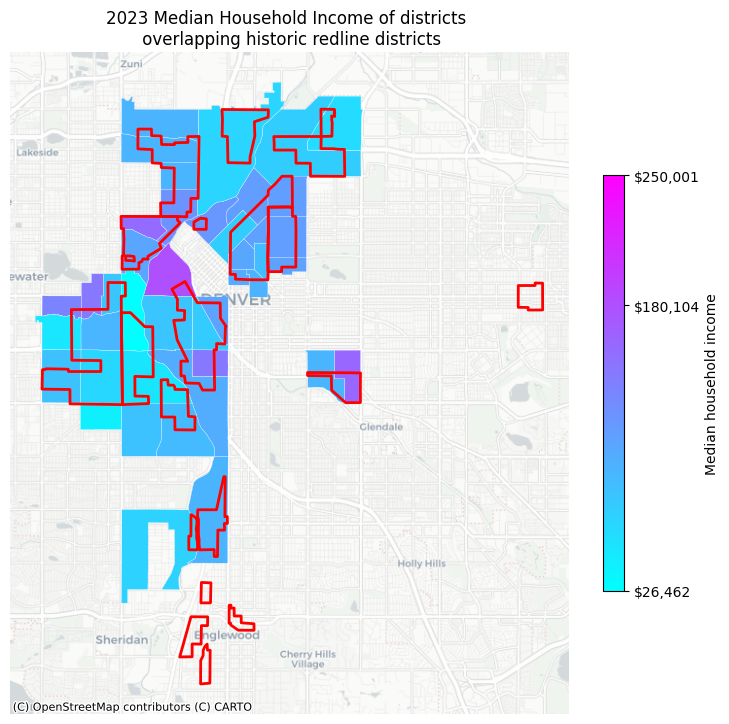

In [34]:
# this visualization also includes the outlines of the 1938 redlined districts
fig, ax = plt.subplots(figsize=(9, 9))

redlined.plot(
    column="median_income",
    cmap="cool",
    legend=True,
    legend_kwds={
        "ticks":[vmax_all,vmax_red,vmin_red],
        "label": "Median household income",
        "format": '${x:,.0f}',
        "shrink": 0.6,
    },
    linewidth=0.2,
    edgecolor="white",
    ax=ax,
    vmax=vmax_all,
    vmin=vmin_all
)

original_redlined = denver_gdf_3857.loc[denver_gdf_3857["grade"]=='D']
original_redlined.plot(
    ax=ax,
    facecolor='none', # makes it an outline
    edgecolor='red',
    linewidth=2,
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=12)

ax.set_title("2023 Median Household Income of districts \n overlapping historic redline districts")
ax.set_axis_off()
plt.show()

An interesting thing to note is that you can see that even some of these 2023 districts with higher income, there is actually only a small overlap between that district and the historic district such as the example below

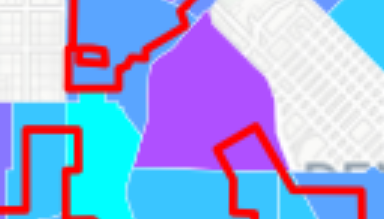

In [35]:
display.Image("./overlap_example.png")

## Summary

This project answered the question. **YES** The effects of redlining are still felt today. The practice has been illegal for decades but we are still dealing with its consequences.

Neighborhoods that were redlined in 1938 have been under funded, abandoned, and left to rot leading to a long term lower median household income. While highly graded districts recieved ample investments and funding leading to their long term success and higher average median income. 

While I am glad I was able to answer the question posed. I hope this project and help spread awareness about this seldom talked about history.